# practical_exercise_8 , Methods 3, 2021, autumn semester
### Laura W. Paaby
### 1/12 - 2021

# Exercises and objectives
1) Load the magnetoencephalographic recordings and do some initial plots to understand the data
2) Do logistic regression to classify pairs of PAS-ratings
3) Do a Support Vector Machine Classification on all four PAS-ratings
REMEMBER: In your report, make sure to include code that can reproduce the answers requested in the
exercises below (MAKE A KNITTED VERSION)
REMEMBER: This is Assignment 3 and will be part of your final portfolio

# EXERCISE 1 - Load the magnetoencephalographic recordings and do some initial plots to understand the data

1) Load megmag_data.npy and call it data using np.load. You can use join, which can be imported
from os.path, to create paths from different string segments
i. The data is a 3-dimensional array. The first dimension is number of repetitions of a visual stimulus, the second dimension is the number of sensors that record magnetic fields (in Tesla) that stem from neurons activating in the brain, and the third dimension is the number of time samples. How many repetitions, sensors and time samples are there?

In [1]:
## importing libraries
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
import scipy as sp
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os

In [2]:
data = np.load("/Users/laura/Desktop/megmag_data.npy")

#numbers of repitions of visual stimuli: 682
#numbers of sensors (spots in the cap that record magnetic fields): 102
#numbers of time samples: 251
#### this is found by:
print(data.shape)

(682, 102, 251)


ii. The time range is from (and including) -200 ms to (and including) 800 ms with a sample recorded every 4 ms. At time 0, the visual stimulus was briefly presented. Create a 1-dimensional array called `times` that represents this.  

In [3]:
#creating array of time samples:
time_array = np.arange(-200, 804, 4)

iii. Create the sensor covariance matrix $\Sigma_{XX}$: $$\Sigma_{XX} = \frac 1 N \sum_{i=1}^N XX^T$$ $N$ is the number of repetitions and $X$ has $s$ rows and $t$ columns (sensors and time), thus the shape is $X_{s\times t}$. Do the sensors pick up independent signals? (Use `plt.imshow` to plot the sensor covariance matrix)  

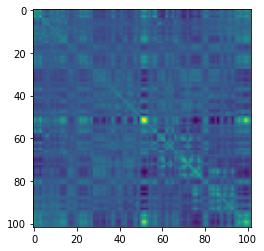

In [4]:
n = 682
cov_mat = []

#calculating the dot product for all rows i using all datapoints in the dimensions
for i in range(n):
    cov_mat.append(data[i,:,:] @ data[i,:,:].T)

#out of the loop the dot product of the the matrices for each i is summed and divided by n.
cov_mat = sum(cov_mat)/n

#plotting the covariance matrix
plt.imshow(cov_mat)

iv. Make an average over the repetition dimension using `np.mean` - use the `axis` argument. (The resulting array should have two dimensions with time as the first and magnetic field as the second)  

In [5]:
### we take the mean of all the repetions, the first axis = 0 - this now gives us all the values for sensors and time samples in this exact point (the mean) on the repetition axes 
rep_mean = np.mean(data, axis=0)
###this should be transposed ?????
print(rep_mean.shape)

(102, 251)


 v. Plot the magnetic field (based on the average) as it evolves over time for each of the sensors (a line for each) (time on the x-axis and magnetic field on the y-axis). Add a horizontal line at $y = 0$ and a vertical line at $x = 0$ using `plt.axvline` and `plt.axhline`  

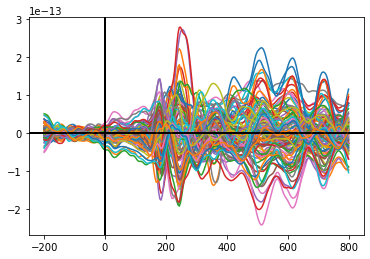

In [6]:
for i in range (102):
    plt.plot(time_array, rep_mean[i,:])
    plt.axvline(0,0, color = "black")
    plt.axhline(0,0, color = "black")

 vi. Find the maximal magnetic field in the average. 
Then use `np.argmax` and `np.unravel_index` to find the sensor that has the maximal magnetic field. 

In [7]:
#finding the max - but this gives a coordinate in the dataframe of mean times:
maxi_mag = np.unravel_index(np.argmax(rep_mean), rep_mean.shape)
print(maxi_mag) #sensor 73, repition 112
#the coordinates can be printed as a number:
print(rep_mean[73,112])
# = 2.7886216843591933e-13 which is a super small number, yet it is our maximum. 

(73, 112)
2.7886216843591933e-13


vii. Plot the magnetic field for each of the repetitions (a line for each) for the sensor that has the maximal magnetic field. Highlight the time point with the maximal magnetic field in the average (as found in 1.1.v) using `plt.axvline`  


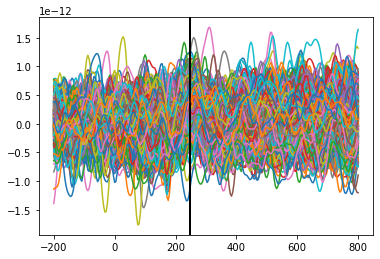

In [8]:
## this is sensor 73 - we wanna plot the repitions and times for this exactly 
for i in range(len(data[:, 73, 0])):
    plt.plot(time_array, data[i,73,:])
    plt.axvline(time_array[112], color = "black")
    
    
#### this is actually not on the right spot - maybe it should have been transposed, so the line is at x = 112????
#### we have plottet the 112 timepoint, which is not corresponding to the x axes. 

 viii. Describe in your own words how the response found in the average is represented in the single repetitions. 
But do make sure to use the concepts _signal_ and _noise_ and comment on any differences on the range of values on the y-axis:

*sooo we see the differences in the single repitions plot (the latter), and the average (the first with the black cross) in the distribution around y = 0.* 
*Firstly we found how sensor 73 is the one with the highest magnetic fields*

*a lot other can be written here )*

### 2) Now load `pas_vector.npy` (call it `y`). 
#### PAS is the same as in Assignment 2, describing the clarity of the subjective experience the subject reported after seeing the briefly presented stimulus  

In [9]:
vector_y = np.load("/Users/laura/Desktop/pas_vector.npy")

i. Which dimension in the `data` array does it have the same length as?  

In [10]:
print(vector_y.shape)

(682,)


 ii. Now make four averages (As in Exercise 1.1.iii), one for each PAS rating, and plot the four time courses (one for each PAS rating) for the sensor found in Exercise 1.1.v  

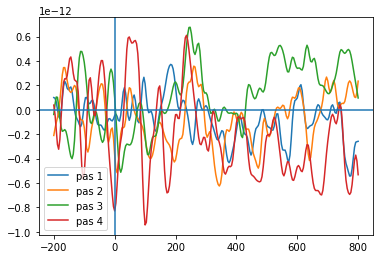

In [11]:
pas1 = []
pas2 = []
pas3 = []
pas4 = []
for i in range(682):
    if vector_y[i] == 1:
      pas1.append(vector_y[i])
    if vector_y[i] == 2:
      pas2.append(vector_y[i])
    if vector_y[i] == 3:
      pas3.append(vector_y[i])
    if vector_y[i] == 4:
     pas4.append(vector_y[i])
     
#making new df only for73
sensor73 = data[:,73,:]      
avgpas1 = np.mean(sensor73[pas1], axis = 0)
avgpas2 = np.mean(sensor73[pas2], axis = 0)
avgpas3 = np.mean(sensor73[pas3], axis = 0)
avgpas4 = np.mean(sensor73[pas4], axis = 0)

#plotting it 
plt.figure()
plt.plot(time_array, avgpas1)
plt.plot(time_array, avgpas2)
plt.plot(time_array, avgpas3)
plt.plot(time_array, avgpas4)
plt.axvline()
plt.axhline()
plt.legend(['pas 1', 'pas 2', 'pas 3', 'pas 4'])
plt.show()

## this now show the mean of all magnitudes in the respective pass    


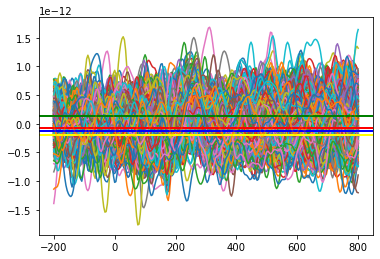

In [12]:
#this shows how pas2 has the lowest magnitude score, pas3 the highest, and 1 and 4 being in the middle - not as one might have expected. 
#Since the magnitude should seem to correspond with the clarity of the subjective experience. but this does not seem to be the case - wild guess here"""

###finding the mean for each pass on sensor 73:
s_pas_one = [i for i, x in enumerate(vector_y) if x == 1 ]
s_pas_1 = data[s_pas_one,73,:]#saving this in new frame
1
s_pas_two = [i for i, x in enumerate(vector_y) if x == 2 ]
s_pas_2 = data[s_pas_two,73,:]#saving this in new frame

s_pas_three = [i for i, x in enumerate(vector_y) if x == 3 ]
s_pas_3 = data[s_pas_three,73,:]

s_pas_four = [i for i, x in enumerate(vector_y) if x == 4]
s_pas_4 = data[s_pas_four,73,:]
 
    
for i in range(len(data[:, 73, 0])):
    plt.plot(time_array, data[i,73,:])
    plt.axhline(y = np.mean(s_pas_1[0]), color = "blue")
    plt.axhline(y = np.mean(s_pas_2[0]), color = "yellow")
    plt.axhline(y = np.mean(s_pas_3[0]), color = "green")
    plt.axhline(y = np.mean(s_pas_4[0]), color = "red")

 iii. Notice that there are two early peaks (measuring visual activity from the brain), one before 200 ms and one around 250 ms. Describe how the amplitudes of responses are related to the four PAS-scores. Does PAS 2 behave differently than expected?  
 
 *here a cool explaining could be given - not by me*

#   EXERCISE 2 - Do logistic regression to classify pairs of PAS-ratings 

### 1) Now, we are going to do Logistic Regression with the aim of classifying the PAS-rating given by the subject  
 i. We'll start with a binary problem - create a new array called `data_1_2` that only contains PAS responses 1 and 2. Similarly, create a `y_1_2` for the target vector  

In [13]:
list_y = np.argwhere((vector_y ==1) | (vector_y == 2))
y_1_2 = vector_y[list_y]


#finding pas one and two of the data:
pas_one = [i for i, x in enumerate(vector_y) if x ==1 ]
#this list can now be used index the matching numbers out of the data - we should have 99 reps,since this is the amount of passes:
print(data[pas_one,:,:].shape)

## pas two 
pas_two = [i for i, x in enumerate(vector_y) if x == 2 ]
print(data[pas_two,:,:].shape)


#taking the target values for each pass and saved them into data_1_2
data_one = data[pas_one,:,:]
data_two = data[pas_two,:,:]
data_1_2 = np.squeeze(np.concatenate((data_one,data_two), axis = 0))


##looking at the length to make sure they are the same
print(data_1_2.shape)

(99, 102, 251)
(115, 102, 251)
(214, 102, 251)


ii. Scikit-learn expects our observations (`data_1_2`) to be in a 2d-array, which has samples (repetitions) on dimension 1 and features (predictor variables) on dimension 2. Our `data_1_2` is a three-dimensional array. Our strategy will be to collapse our two last dimensions (sensors and time) into one dimension, while keeping the first dimension as it is (repetitions). Use `np.reshape` to create a variable `X_1_2` that fulfils these criteria.  

In [14]:
X_1_2 = data_1_2.transpose(0,1,2).reshape(-1,data_1_2.shape[0])
print(X_1_2.shape)
#this appears to be right since the shape now is the collapsed data in the 25602 row and the 214 repitions are the columns. 


(25602, 214)


iii. Import the `StandardScaler` and scale `X_1_2` 

In [15]:
#reshapingen 
X_1_2_reshaped = X_1_2.reshape(214, 25602)


## splitting the data so we can test how well it classifies the test set:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1_2_reshaped, y_1_2, test_size=0.2, random_state=0)

#making everything on the same scale
sc = StandardScaler()
sc.fit(X_1_2_reshaped)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

iv. Do a standard `LogisticRegression` - can be imported from `sklearn.linear_model` - make sure there is no `penalty` applied  

In [16]:
logR = LogisticRegression(penalty='none') # no regularisation
logR.fit(X_train_std, y_train)
print(logR.score(X_train_std, y_train))

/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0


 v. Use the `score` method of `LogisticRegression` to find out how many labels were classified correctly. Are we overfitting? Besides the score, what would make you suspect that we are overfitting?  

In [17]:
print(logR.score(X_test_std, y_test))
#### this means that the printed value (around 55) of the classifications are correct. 
## this is not very much, which might could be explained by overfitting of the test data. The model are therefore not generalisable, and classifies the test data quite badly.
## if the model was not overfitted to the train data, we would expect it to be a better classifier - maybe we should penalizzzzze it 


0.5581395348837209


vi. Now apply the _L1_ penalty instead - how many of the coefficients (`.coef_`) are non-zero after this?  

In [18]:
log_l1 = LogisticRegression(penalty = 'l1', solver = 'liblinear') # set 
log_l1.fit(X_train_std, y_train)
print(log_l1.score(X_train_std, y_train))

print(log_l1.score(X_test_std, y_test))
#now that we have fitted the new penalized model we can check how many of the coefficients are not equal to zero
#this actually has a lower accuracy of classification 

/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0
0.46511627906976744


In [20]:
#finding the zeros 
l1_coef = log_l1.coef_
zero = np.count_nonzero(l1_coef == 0)
print(zero) #this is the amounts of 0's 
non_zero = np.count_nonzero(l1_coef != 0)
print(non_zero) #this is the amounts of non 0's 

25375
227


vii. Create a new reduced $X$ that only includes the non-zero coefficients - show the covariance of the non-zero features (two covariance matrices can be made; $X_{reduced}X_{reduced}^T$ or $X_{reduced}^TX_{reduced}$ (you choose the right one)) . Plot the covariance of the features using `plt.imshow`. Compared to the plot from 1.1.iii, do we see less covariance?  

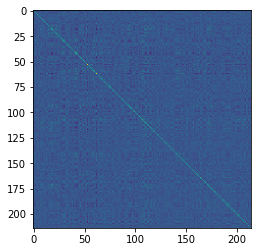

In [21]:
log1_coef_0 = np.where(l1_coef!= 0)[1]
log1_coef_0.shape

reduced_X=X_1_2_reshaped[:,log1_coef_0]
reduced_X.shape

plt.imshow(np.cov(reduced_X))

### 2) Now, we are going to build better (more predictive) models by using cross-validation as an outcome measure 

i. Import `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection`  

In [22]:
from sklearn.model_selection import cross_val_score, StratifiedKFold 

ii. To make sure that our training data sets are not biased to one target (PAS) or the other, create `y_1_2_equal`, which should have an equal number of each target. 
Create a similar `X_1_2_equal`. The function `equalize_targets_binary` in the code chunk associated with Exercise 2.2.ii can be used. 
Remember to scale `X_1_2_equal`!  

In [23]:
def equalize_targets_binary(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) > 2:
        raise NameError ("can't have more than two targets") #may only be binary
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count,replace=False)
    # create the new data sets
    new_indices = np.concatenate((first_choice, second_choice))
    new_y = y[new_indices]

    new_data = data[new_indices, :, :]
    return new_data, new_y


#creating the new x and y
X_1_2_equal_new_o, y_1_2_equal_new = equalize_targets_binary(data_1_2, y_1_2)

#to be able to standardice, we must reshape it to be 2 dim
X_1_2_equal_new = X_1_2_equal_new_o.reshape(198,-1)


# standardizing 
sc = StandardScaler()
X_1_2_equal_std = sc.fit_transform(X_1_2_equal_new)



  iii. Do cross-validation with 5 stratified folds doing standard `LogisticRegression` (See Exercise 2.1.iv)

In [24]:
k_fold = StratifiedKFold(n_splits = 5, random_state = 2, shuffle = True).split(X_1_2_equal_std, y_1_2_equal_new)


In [25]:
#loop finding the cross validation scores:
lr = LogisticRegression(penalty = 'l1', solver = 'liblinear')
scores = cross_val_score(lr, X_1_2_equal_std, y_1_2_equal_new[:,0], scoring='accuracy', cv=5)
print(scores)                                                         

##this is across all 5 folds, therefore the mean is taken to summarize the score of the model:
mean_score = np.mean(scores)
print(mean_score)

#this is the mean accuracy of the classification of the leaved out k-folds across all 5 folds of the data. 

[0.55       0.6        0.55       0.46153846 0.38461538]
0.5092307692307692


iv. Do L2-regularisation with the following `Cs =  [1e5, 1e1, 1e-5]`. Use the same kind of cross-validation as in Exercise 2.2.iii. In the best-scoring of these models, how many more/fewer predictions are correct (on average)?  

In [26]:
## C = 1e5
lr_5 = LogisticRegression(C = 1e5, penalty = 'l2', solver = 'liblinear', random_state = 2)
scores_5 = cross_val_score(lr_5, X_1_2_equal_std, y_1_2_equal_new[:,0], scoring='accuracy', cv=5)
print(np.mean(scores_5))

## C = 1e1
lr_1 = LogisticRegression(C = 1e1, penalty = 'l2', solver = 'liblinear', random_state = 2)
scores_1 = cross_val_score(lr_1, X_1_2_equal_std, y_1_2_equal_new[:,0], scoring='accuracy', cv=5)
print(np.mean(scores_1))

## C = 1e-5
lr__5 = LogisticRegression(C = 1e-5, penalty = 'l2', solver = 'liblinear', random_state = 2)
scores__5 = cross_val_score(lr__5, X_1_2_equal_std, y_1_2_equal_new[:,0], scoring='accuracy', cv=5)
print(np.mean(scores__5))


#but why is this under due to chance??????? 
##maybe seet, maybe a mistake .... 

0.46987179487179487
0.47000000000000003
0.4805128205128205


 v. Instead of fitting a model on all `n_sensors * n_samples` features, fit  a logistic regression (same kind as in Exercise 2.2.iv (use the `C` that resulted in the best prediction)) for __each__ time sample and use the same cross-validation as in Exercise 2.2.iii. 
 What are the time points where classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)  


In [28]:
time_scores = []
lr_new = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=1e5)
X_1_2_equal, y_1_2_equal = equalize_targets_binary(data_1_2, y_1_2)

for time_ofs in range(data_1_2.shape[2]):
  X_1_2_equal_time = X_1_2_equal[:, :, time_ofs].squeeze() 
  sc.fit(X_1_2_equal_time)
  X_1_2_equal_std = sc.transform(X_1_2_equal_time)
  time_s = cross_val_score(lr_new, X_1_2_equal_std, y_1_2_equal, cv=5)
  score = np.mean(time_s)
  time_scores.append(score)
print('\nCompleted fitting time-based models')


time_scores = np.array(time_scores) #this is the mean of accuracy across all time samples 

/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laura/opt/miniconda3/envs/methods3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning

In [ ]:
#finding the position of the max scores
max_score_pos = np.unravel_index(np.argmax(time_scores), time_scores.shape)
print(time_scores[max_score_pos])
#this is now the max score 


#plotting
plt.plot(time_array, time_scores) 
plt.axvline(x = max_score_pos, color = 'r')
plt.xlabel("time")
plt.ylabel("cv scores for each time sample")
plt.title("CV scores across time sample, c = 1e-1")
plt.show()